In [ ]:
# correlation graphics 12 seeds ERM

In [ ]:
# Objective:
# To check whether, when the model strongly encodes attributes such as sex, race, etc. (→ LR test AUROC),
# the fairness gap also increases. 
# to confirm the presence of demographic shortcuts


In [ ]:
# NOTE: The difference is computed as C0 − C1 (C0, C1)
# The fairness gap is expressed as a percentage

In [38]:
from pathlib import Path
import json
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

In [39]:
def process_corr_results(attr_name: str, base_dir: Path, results_dir: Path, fairness_classes=(0, 1)):
    dirs = []
    overall_results = []
    test_results_attr = []
    lr_cond_avg_results = []

    c0, c1 = fairness_classes  # c0 will be subtracted from c1

    for i in base_dir.glob('**/done_eval'):
        dirs.append(str(i.parent))
        args = json.load((i.parent / 'args.json').open('r'))

        run_dir = base_dir / args['store_name'] / 'final_results_eval.pkl'
        with open(run_dir, "rb") as f:
            results = pickle.load(f)

        # Overall Test results
        results_te_overall = results['te']['overall']
        df_results_te_overall = pd.DataFrame.from_dict(results_te_overall, orient='index')

        # Overall Val results
        results_va_overall = results['va']['overall']
        df_results_va_overall = pd.DataFrame.from_dict(results_va_overall, orient='index')

        # Test results per attribute
        results_te_attr = results['te']['per_attribute']
        df_te_attr = pd.DataFrame(results_te_attr)

        # Fairness Gap
        if args['task'] == "No Finding":
            fair_gap = (df_te_attr.loc['FPR_opt'][c0] - df_te_attr.loc['FPR_opt'][c1]) * 100
            fair_metric = 'FPR_opt'
        else:
            fair_gap = (df_te_attr.loc['FNR_opt'][c0] - df_te_attr.loc['FNR_opt'][c1]) * 100
            fair_metric = 'FNR_opt'

        # Store overall results
        overall_results.append({
            'store_name': args['store_name'],
            'seed': args['seed'],
            'hparams_seed': args['hparams_seed'],
            'task': args['task'],
            'AUROC_te': df_results_te_overall.loc['AUROC'].values[0],
            'balanced_acc_opt_te': df_results_te_overall.loc['balanced_acc_opt'].values[0],
            'FNR_opt_te': df_results_te_overall.loc['FNR_opt'].values[0],
            'FPR_opt_te': df_results_te_overall.loc['FPR_opt'].values[0],
            'f1_macro_opt_te': results_te_overall['macro_avg__opt']['f1-score'], 
            'AUROC_va': df_results_va_overall.loc['AUROC'].values[0],
            'balanced_acc_opt_va': df_results_va_overall.loc['balanced_acc_opt'].values[0],
            'FNR_opt_va': df_results_va_overall.loc['FNR_opt'].values[0],
            'FPR_opt_va': df_results_va_overall.loc['FPR_opt'].values[0],
            'f1_macro_opt_va': results_va_overall['macro_avg__opt']['f1-score'] 
        })

        #Store results per attribute (demographic subgroups)
        test_results_attr.append({
            'store_name': args['store_name'],
            'seed': args['seed'],
            'hparams_seed': args['hparams_seed'],
            'task': args['task'],
            f'AUROC_attr{c0}': df_te_attr.loc['AUROC'][c0],
            f'AUROC_attr{c1}': df_te_attr.loc['AUROC'][c1],
            f'balanced_acc_attr{c0}': df_te_attr.loc['balanced_acc_opt'][c0],
            f'balanced_acc_attr{c1}': df_te_attr.loc['balanced_acc_opt'][c1],
            f'FNR_opt_attr{c0}': df_te_attr.loc['FNR_opt'][c0],
            f'FNR_opt_attr{c1}': df_te_attr.loc['FNR_opt'][c1],
            f'FPR_opt_attr{c0}': df_te_attr.loc['FPR_opt'][c0],
            f'FPR_opt_attr{c1}': df_te_attr.loc['FPR_opt'][c1],
            'fair_gap': fair_gap,
            'fair_metric': fair_metric,
            'fair_gap_desc': f'{fair_metric} class {c0} - class {c1}'
        })

        # Store conditional avg logistic regression results
        df_results_lr_cond_avg = pd.DataFrame(results['lr_cond_avg'])
        lr_cond_avg_results.append({
            'store_name': args['store_name'],
            'seed': args['seed'],
            'hparams_seed': args['hparams_seed'],
            'task': args['task'],
            'balanced_acc_va': df_results_lr_cond_avg.loc['balanced_acc']['va'],
            'balanced_acc_te': df_results_lr_cond_avg.loc['balanced_acc']['te'],
            'AUROC_va': df_results_lr_cond_avg.loc['AUROC']['va'],
            'AUROC_te': df_results_lr_cond_avg.loc['AUROC']['te'],
            f'class_{c0}_AUROC_va': df_results_lr_cond_avg.loc[f'class_{c0}_AUROC']['va'],
            f'class_{c0}_AUROC_te': df_results_lr_cond_avg.loc[f'class_{c0}_AUROC']['te'],
            f'class_{c1}_AUROC_va': df_results_lr_cond_avg.loc[f'class_{c1}_AUROC']['va'],
            f'class_{c1}_AUROC_te': df_results_lr_cond_avg.loc[f'class_{c1}_AUROC']['te']
        })

    print(f'Total runs for {attr_name}:', len(dirs))

    # Create and save DataFrames
    df_overall = pd.DataFrame(overall_results)
    df_attr = pd.DataFrame(test_results_attr)
    df_lr = pd.DataFrame(lr_cond_avg_results)

    results_dir.mkdir(parents=True, exist_ok=True)
    df_overall.to_csv(results_dir / f'overall_results_all_{attr_name}.csv', index=False)
    df_attr.to_csv(results_dir / f'test_results_attr_{attr_name}.csv', index=False)
    df_lr.to_csv(results_dir / f'lr_results_all_{attr_name}.csv', index=False)

    print(f"CSV guardados en: {results_dir}")
    return df_overall, df_attr, df_lr


In [40]:
def merge_dfs(df_overall, df_attr, df_lr, attr_name):
    # Rename columns
    df_lr = df_lr.rename(columns={'AUROC_te': 'attr_lr_auroc_te'})
    df_overall = df_overall.rename(columns={'AUROC_va': 'overall_val_auroc'})

    # Merge using store_name and task
    df = df_attr.merge(df_lr, on=['store_name', 'seed', 'hparams_seed' ,'task'])
    df = df.merge(df_overall[['store_name', 'task', 'overall_val_auroc']], on=['store_name', 'task'])

    df['attribute'] = attr_name
    return df


In [41]:
def pearson_ci(r, n, alpha=0.05):
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    z_crit = 1.96  # 95% CI
    
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    
    r_lower = (np.exp(2*z_lower) - 1) / (np.exp(2*z_lower) + 1)
    r_upper = (np.exp(2*z_upper) - 1) / (np.exp(2*z_upper) + 1)
    
    return r_lower, r_upper

def slope_ci(X,y):  
    X = sm.add_constant(X)  
    model = sm.OLS(y, X).fit()

    slope = model.params['fair_gap']
    intercept = model.params['const']
    pval_slope = model.pvalues['fair_gap']
    pval_intercept = model.pvalues['const']
    r_squared = model.rsquared
    slope_95ci = model.conf_int().loc['fair_gap']

    return slope, intercept, pval_slope, pval_intercept, r_squared, slope_95ci

In [71]:
def plot_fairness_vs_attr_auroc(df_all_attrs):

    results_plots=[]
    
    sns.set(style='whitegrid')
    
    # Get unique combinations of task and attribute
    combinations = df_all_attrs[['task', 'attribute']].drop_duplicates()
    n_plots = len(combinations)

    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 4), squeeze=False)
    axes = axes[0] # flatten if there is only one row

    for ax, (_, row) in zip(axes, combinations.iterrows()):
        task = row['task']
        attr = row['attribute']
        
        # Filter by task and attribute
        sub_df = df_all_attrs[(df_all_attrs['task'] == task) & (df_all_attrs['attribute'] == attr)]

        # Exclude suboptimal models
        sub_df = sub_df[sub_df['overall_val_auroc'] >= 0.7]

        x = sub_df['fair_gap']
        y = sub_df['attr_lr_auroc_te']
        
        if len(sub_df) >= 2:
            r, p = pearsonr(x, y)

            n = len(x)
            r_95ci_lower, r_95ci_upper=pearson_ci(r,n) 

            slope, intercept, pval_slope, pval_intercept, r_squared, slope_95ci = slope_ci(x, y)

        else:
            r, p = float('nan'), float('nan')
            r_95ci_lower, r_95ci_upper = float('nan'), float('nan')
            slope, intercept = float('nan'), float('nan')
            pval_slope, pval_intercept = float('nan'), float('nan')
            r_squared, slope_95ci = float('nan'), float('nan')
        

        results_plots.append({
            'task': task,
            'attr': attr,
            'r':r,
            'p':p,
            'r_95ci_lower':r_95ci_lower,
            'r_95ci_upper':r_95ci_upper,
            'r_95ci_dif': r_95ci_upper - r_95ci_lower,
            'slope': slope,
            'intercept': intercept,
            'pval_slope': pval_slope,
            'slope_95ci_lower': slope_95ci[0],
            'slope_95ci_upper': slope_95ci[1],
            'slope_95ci_dif': slope_95ci[1]-slope_95ci[0],
            'r_squared': r_squared
        })

        print("results")
        print(task)
        print(attr)
        print("valores con overall_val_auroc > 0.7: ", len(sub_df))
        print("r = ", r)
        print("p = ", p)
        
        
        # regplot: plot data and fit a linear regression model
        # (95% confidence interval for the regression line)
        sns.regplot(data=sub_df, x='fair_gap', y='attr_lr_auroc_te',
                    ax=ax, scatter_kws={'s': 40}, line_kws={'color': 'black'})

        ax.set_title(f"ERM: {task}, {attr.capitalize()} \nR = {r:.2f}, P = {p:.1e}", fontsize=12)
        ax.set_xlabel("Fairness gap (%)")
        ax.set_ylabel("Attribute prediction AUROC")

    plt.tight_layout()
    plt.show()

    df_results_plots = pd.DataFrame(results_plots)

    # Sort results
    task_order = ['No Finding', 'Pleural Effusion', 'Cardiomegaly', 'Pneumothorax']
    df_results_plots['task'] = pd.Categorical(df_results_plots['task'], categories=task_order, ordered=True)
    df_results_plots = df_results_plots.sort_values('task')
    
    return df_results_plots

In [ ]:
#==========================SEX=====================================

In [43]:
# Load sex results: for sex: female (0) – male (1): 0 − 1

df_overall_sex, df_attr_sex, df_lr_sex=process_corr_results(
    attr_name='sex',
    base_dir=Path('/home/lchanch/initial_training/output_sweep_12/grid_sex_mimic_12'),
    results_dir=Path('/home/lchanch/models/ERM/eval/corr_eval/'),
    fairness_classes=(0, 1)
)

Total runs for sex: 136
CSV guardados en: /home/lchanch/models/ERM/eval/corr_eval


In [44]:
df_overall_sex.head()

,store_name,seed,hparams_seed,task,AUROC_te,balanced_acc_opt_te,FNR_opt_te,FPR_opt_te,f1_macro_opt_te,AUROC_va,balanced_acc_opt_va,FNR_opt_va,FPR_opt_va,f1_macro_opt_va
0,d625628b73ed041fe6e242b79f4575e3,1,7,Cardiomegaly,0.801891,0.728819,0.206678,0.335684,0.628487,0.805573,0.732185,0.197374,0.338256,0.629942
1,5b13d76ffe1c4e5727a28d8dc8cf4ad7,1,11,Cardiomegaly,0.521601,0.521601,0.822144,0.134653,0.522232,0.520238,0.520238,0.824282,0.135242,0.520715
2,7446e1af1146a1fe82ffb966c98540d5,0,4,Cardiomegaly,0.562549,0.562549,0.335794,0.539108,0.462493,0.566794,0.566794,0.315866,0.550547,0.460617
3,b781cd45b64b83c4329776e029748840,2,11,Pneumothorax,0.502025,0.502025,0.966972,0.028978,0.501779,0.508278,0.508278,0.955757,0.027688,0.509124
4,0bdd44bdd53fb5f084305a8aa360675e,1,11,Pleural Effusion,0.500000,0.500000,1.000000,0.000000,0.438590,0.500000,0.500000,1.000000,0.000000,0.437303


In [45]:
df_attr_sex.head()

,store_name,seed,hparams_seed,task,AUROC_attr0,AUROC_attr1,balanced_acc_attr0,balanced_acc_attr1,FNR_opt_attr0,FNR_opt_attr1,FPR_opt_attr0,FPR_opt_attr1,fair_gap,fair_metric,fair_gap_desc
0,d625628b73ed041fe6e242b79f4575e3,1,7,Cardiomegaly,0.808297,0.796794,0.734544,0.723310,0.177286,0.234004,0.353626,0.319376,-5.671808,FNR_opt,FNR_opt class 0 - class 1
1,5b13d76ffe1c4e5727a28d8dc8cf4ad7,1,11,Cardiomegaly,0.519601,0.523233,0.519601,0.523233,0.804232,0.838797,0.156566,0.114737,-3.456568,FNR_opt,FNR_opt class 0 - class 1
2,7446e1af1146a1fe82ffb966c98540d5,0,4,Cardiomegaly,0.558617,0.565967,0.558617,0.565967,0.320768,0.349763,0.561998,0.518303,-2.899412,FNR_opt,FNR_opt class 0 - class 1
3,b781cd45b64b83c4329776e029748840,2,11,Pneumothorax,0.496686,0.505520,0.496686,0.505520,0.980416,0.957428,0.026211,0.031532,2.298783,FNR_opt,FNR_opt class 0 - class 1
4,0bdd44bdd53fb5f084305a8aa360675e,1,11,Pleural Effusion,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,FNR_opt,FNR_opt class 0 - class 1


In [46]:
df_lr_sex.head()

,store_name,seed,hparams_seed,task,balanced_acc_va,balanced_acc_te,AUROC_va,AUROC_te,class_0_AUROC_va,class_0_AUROC_te,class_1_AUROC_va,class_1_AUROC_te
0,d625628b73ed041fe6e242b79f4575e3,1,7,Cardiomegaly,0.675214,0.682781,0.742908,0.745083,0.742908,0.745083,0.742908,0.745083
1,5b13d76ffe1c4e5727a28d8dc8cf4ad7,1,11,Cardiomegaly,0.555421,0.546503,0.587924,0.578179,0.587924,0.578179,0.587924,0.578179
2,7446e1af1146a1fe82ffb966c98540d5,0,4,Cardiomegaly,0.535460,0.539122,0.578682,0.593234,0.578682,0.593234,0.578682,0.593234
3,b781cd45b64b83c4329776e029748840,2,11,Pneumothorax,0.519164,0.526381,0.546871,0.544561,0.546871,0.544561,0.546871,0.544561
4,0bdd44bdd53fb5f084305a8aa360675e,1,11,Pleural Effusion,0.562025,0.564910,0.601116,0.601164,0.601116,0.601164,0.601116,0.601164


In [47]:
df_sex=merge_dfs(df_overall_sex, df_attr_sex, df_lr_sex, 'sex')
df_sex.head()

,store_name,seed,hparams_seed,task,AUROC_attr0,AUROC_attr1,balanced_acc_attr0,balanced_acc_attr1,FNR_opt_attr0,FNR_opt_attr1,...,balanced_acc_va,balanced_acc_te,AUROC_va,attr_lr_auroc_te,class_0_AUROC_va,class_0_AUROC_te,class_1_AUROC_va,class_1_AUROC_te,overall_val_auroc,attribute
0,d625628b73ed041fe6e242b79f4575e3,1,7,Cardiomegaly,0.808297,0.796794,0.734544,0.723310,0.177286,0.234004,...,0.675214,0.682781,0.742908,0.745083,0.742908,0.745083,0.742908,0.745083,0.805573,sex
1,5b13d76ffe1c4e5727a28d8dc8cf4ad7,1,11,Cardiomegaly,0.519601,0.523233,0.519601,0.523233,0.804232,0.838797,...,0.555421,0.546503,0.587924,0.578179,0.587924,0.578179,0.587924,0.578179,0.520238,sex
2,7446e1af1146a1fe82ffb966c98540d5,0,4,Cardiomegaly,0.558617,0.565967,0.558617,0.565967,0.320768,0.349763,...,0.535460,0.539122,0.578682,0.593234,0.578682,0.593234,0.578682,0.593234,0.566794,sex
3,b781cd45b64b83c4329776e029748840,2,11,Pneumothorax,0.496686,0.505520,0.496686,0.505520,0.980416,0.957428,...,0.519164,0.526381,0.546871,0.544561,0.546871,0.544561,0.546871,0.544561,0.508278,sex
4,0bdd44bdd53fb5f084305a8aa360675e,1,11,Pleural Effusion,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,...,0.562025,0.564910,0.601116,0.601164,0.601116,0.601164,0.601116,0.601164,0.500000,sex


In [48]:
df_sex_final=df_sex[df_sex['overall_val_auroc'] >= 0.7]
#df_sex_final.to_csv('/home/lchanch/initial_training/results_output_sweep_12/results_corr_graphics/df_sex_up07.csv', index=False)
df_sex_final

,store_name,seed,hparams_seed,task,AUROC_attr0,AUROC_attr1,balanced_acc_attr0,balanced_acc_attr1,FNR_opt_attr0,FNR_opt_attr1,...,balanced_acc_va,balanced_acc_te,AUROC_va,attr_lr_auroc_te,class_0_AUROC_va,class_0_AUROC_te,class_1_AUROC_va,class_1_AUROC_te,overall_val_auroc,attribute
0,d625628b73ed041fe6e242b79f4575e3,1,7,Cardiomegaly,0.808297,0.796794,0.734544,0.723310,0.177286,0.234004,...,0.675214,0.682781,0.742908,0.745083,0.742908,0.745083,0.742908,0.745083,0.805573,sex
6,0696dae89e5a8a103f5302240bce88bf,1,0,Cardiomegaly,0.760060,0.758112,0.697232,0.687900,0.252675,0.294144,...,0.637775,0.640323,0.752762,0.747643,0.752762,0.747643,0.752762,0.747643,0.763404,sex
7,36349d8b189a2c798963d80146124818,2,7,Pleural Effusion,0.928113,0.909710,0.834842,0.823153,0.237492,0.236205,...,0.728191,0.732583,0.808149,0.810435,0.808149,0.810435,0.808149,0.810435,0.918176,sex
8,1a1e111ccdd14e61a1884db47b8d0117,1,1,No Finding,0.855040,0.837175,0.780085,0.765394,0.196132,0.248562,...,0.745685,0.741136,0.825321,0.818572,0.825321,0.818572,0.825321,0.818572,0.844763,sex
9,3d609d9be4f01bd08f2cdc8035005d19,2,1,Pneumothorax,0.866520,0.845326,0.684559,0.700013,0.597307,0.554301,...,0.700191,0.707630,0.776907,0.780297,0.776907,0.780297,0.776907,0.780297,0.862240,sex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,b6b1eb5fbfbd9f0bf5612d9570738c44,2,9,Cardiomegaly,0.814798,0.801306,0.738924,0.722381,0.273833,0.298892,...,0.723821,0.723450,0.808623,0.808480,0.808623,0.808480,0.808623,0.808480,0.811212,sex
129,7bde98af422b0fb0cdde8c1c9d5db60b,1,1,Pleural Effusion,0.932201,0.914186,0.853099,0.837398,0.184024,0.183161,...,0.771737,0.774390,0.857465,0.860229,0.857465,0.860229,0.857465,0.860229,0.921514,sex
131,7622d63da2b713e2842589b753af82f9,2,3,Cardiomegaly,0.728274,0.737226,0.672208,0.672015,0.321741,0.351345,...,0.572818,0.571835,0.652640,0.657865,0.652640,0.657865,0.652640,0.657865,0.740255,sex
133,d3e738a4df3a1a9f8771448e8c0d3051,2,7,No Finding,0.849772,0.829536,0.771627,0.761962,0.191381,0.244452,...,0.687027,0.684078,0.760584,0.760896,0.760584,0.760896,0.760584,0.760896,0.838023,sex


In [49]:
df_sex_corr=df_sex_final[['task','fair_gap','attr_lr_auroc_te']]
df_sex_corr

,task,fair_gap,attr_lr_auroc_te
0,Cardiomegaly,-5.671808,0.745083
6,Cardiomegaly,-4.146915,0.747643
7,Pleural Effusion,0.128689,0.810435
8,No Finding,2.304967,0.818572
9,Pneumothorax,4.300661,0.780297
...,...,...,...
128,Cardiomegaly,-2.505947,0.808480
129,Pleural Effusion,0.086278,0.860229
131,Cardiomegaly,-2.960400,0.657865
133,No Finding,3.374186,0.760896


results
Cardiomegaly
sex
valores con overall_val_auroc > 0.7:  24
r =  -0.13217166227480892
p =  0.5381251608527619
results
Pneumothorax
sex
valores con overall_val_auroc > 0.7:  15
r =  -0.4556637991079759
p =  0.08783324249864334
results
Pleural Effusion
sex
valores con overall_val_auroc > 0.7:  24
r =  0.5446622908228151
p =  0.0059240319403261075
results
No Finding
sex
valores con overall_val_auroc > 0.7:  24
r =  0.650998735200987
p =  0.0005708406745516989


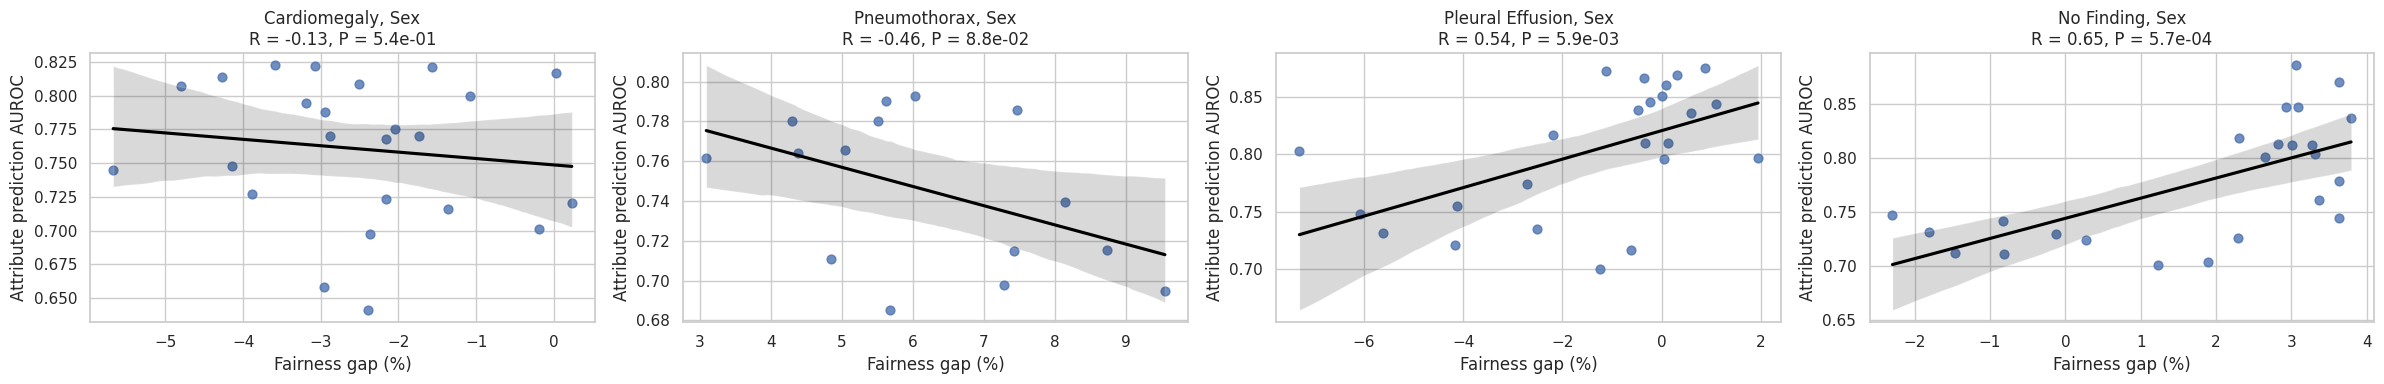

,task,attr,r,p,r_95ci_lower,r_95ci_upper,r_95ci_dif,slope,intercept,pval_slope,slope_95ci_lower,slope_95ci_upper,slope_95ci_dif,r_squared
3,No Finding,sex,0.650999,0.000571,0.335775,0.835094,0.499319,0.018647,0.743828,0.000571,0.009033,0.028260,0.019227,0.423799
2,Pleural Effusion,sex,0.544662,0.005924,0.181036,0.777282,0.596246,0.012415,0.820754,0.005924,0.003963,0.020867,0.016904,0.296657
0,Cardiomegaly,sex,-0.132172,0.538125,-0.508464,0.286508,0.794972,-0.004748,0.748644,0.538125,-0.020491,0.010995,0.031486,0.017469
1,Pneumothorax,sex,-0.455664,0.087833,-0.784754,0.073843,0.858598,-0.009647,0.805202,0.087833,-0.020939,0.001645,0.022584,0.207629


In [50]:
plot_fairness_vs_attr_auroc(df_sex)

In [65]:
df_sex_no_finding = df_sex.loc[
    df_sex['task'] == 'No Finding'
]
df_sex_no_finding

,store_name,seed,hparams_seed,task,AUROC_attr0,AUROC_attr1,balanced_acc_attr0,balanced_acc_attr1,FNR_opt_attr0,FNR_opt_attr1,...,balanced_acc_va,balanced_acc_te,AUROC_va,attr_lr_auroc_te,class_0_AUROC_va,class_0_AUROC_te,class_1_AUROC_va,class_1_AUROC_te,overall_val_auroc,attribute
5,136d3cc1de983b2df20359daa950f7f0,2,2,No Finding,0.563195,0.585195,0.563195,0.585195,0.630132,0.563696,...,0.534751,0.535894,0.546037,0.543487,0.546037,0.543487,0.546037,0.543487,0.581333,sex
8,1a1e111ccdd14e61a1884db47b8d0117,1,1,No Finding,0.855040,0.837175,0.780085,0.765394,0.196132,0.248562,...,0.745685,0.741136,0.825321,0.818572,0.825321,0.818572,0.825321,0.818572,0.844763,sex
18,b101c67ae020ee66020265eeb742bb1a,2,6,No Finding,0.854891,0.836742,0.774601,0.765454,0.159937,0.208289,...,0.733852,0.734149,0.811327,0.811434,0.811327,0.811434,0.811327,0.811434,0.844407,sex
22,553b893e4f642b543a311d8f866828db,1,3,No Finding,0.784406,0.764496,0.718331,0.702381,0.291709,0.305507,...,0.636872,0.645578,0.722015,0.731122,0.722015,0.731122,0.722015,0.731122,0.773844,sex
26,681a2996d9693e7e15602f24fbb184c8,2,9,No Finding,0.856166,0.837789,0.778631,0.768077,0.157109,0.206411,...,0.737431,0.734545,0.814933,0.812379,0.814933,0.812379,0.814933,0.812379,0.844611,sex
29,8f8fae81b6781573591e061174f85529,0,6,No Finding,0.855742,0.835743,0.780167,0.762252,0.213211,0.279911,...,0.765158,0.764107,0.845678,0.846718,0.845678,0.846718,0.845678,0.846718,0.844661,sex
30,168fad471ce0f685d53c9b787d790c95,1,9,No Finding,0.851391,0.833262,0.771561,0.763460,0.151793,0.204297,...,0.784808,0.788321,0.867161,0.870410,0.867161,0.870410,0.867161,0.870410,0.840418,sex
35,69cd5abd7c85e05b3f62981334b5c3ca,2,3,No Finding,0.795791,0.775868,0.728883,0.713710,0.249972,0.265704,...,0.654349,0.650329,0.712576,0.711574,0.712576,0.711574,0.712576,0.711574,0.786586,sex
37,248248fe7fc16111be7f0e72c97f0589,0,7,No Finding,0.848646,0.826740,0.775374,0.752291,0.228029,0.310555,...,0.670242,0.667837,0.746049,0.744049,0.746049,0.744049,0.746049,0.744049,0.834656,sex
38,bdd2ede63265f89b2fb551d826139894,0,5,No Finding,0.854551,0.834615,0.779902,0.762400,0.202466,0.270635,...,0.733049,0.727204,0.809769,0.802983,0.809769,0.802983,0.809769,0.802983,0.842305,sex


results
No Finding
sex
valores con overall_val_auroc > 0.7:  24
r =  0.650998735200987
p =  0.0005708406745516989


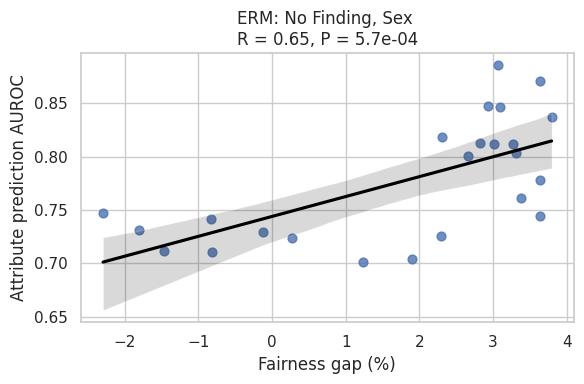

,task,attr,r,p,r_95ci_lower,r_95ci_upper,r_95ci_dif,slope,intercept,pval_slope,slope_95ci_lower,slope_95ci_upper,slope_95ci_dif,r_squared
0,No Finding,sex,0.650999,0.000571,0.335775,0.835094,0.499319,0.018647,0.743828,0.000571,0.009033,0.02826,0.019227,0.423799


In [72]:
plot_fairness_vs_attr_auroc(df_sex_no_finding)

In [ ]:
#==========================SEX=====================================

In [ ]:
#==========================RACE====================================

In [51]:
# Race: 
#white ->0, black -> 1 : class 1 - class 0
df_overall_race, df_attr_race, df_lr_race = process_corr_results(
    attr_name='race',
    base_dir=Path('/home/lchanch/initial_training/output_sweep_12/grid_race_mimic_12'),
    results_dir=Path('/home/lchanch/models/ERM/eval/corr_eval/'),
    fairness_classes=(1, 0)
)

Total runs for race: 134
CSV guardados en: /home/lchanch/models/ERM/eval/corr_eval


In [52]:
df_race=merge_dfs(df_overall_race, df_attr_race, df_lr_race, 'race')
df_race

,store_name,seed,hparams_seed,task,AUROC_attr1,AUROC_attr0,balanced_acc_attr1,balanced_acc_attr0,FNR_opt_attr1,FNR_opt_attr0,...,balanced_acc_va,balanced_acc_te,AUROC_va,attr_lr_auroc_te,class_1_AUROC_va,class_1_AUROC_te,class_0_AUROC_va,class_0_AUROC_te,overall_val_auroc,attribute
0,c60d92463516d8ba5a25fab8dfc14d70,2,7,Cardiomegaly,0.824768,0.800233,0.738127,0.716594,0.314599,0.327842,...,0.256112,0.256359,0.660422,0.647996,0.672038,0.665628,0.650842,0.646233,0.807013,race
1,359f2b34389f45be0d316685d88d17ed,1,0,Pleural Effusion,0.898575,0.897255,0.771582,0.789151,0.397634,0.325398,...,0.250145,0.250196,0.624575,0.620142,0.611578,0.612714,0.612895,0.611433,0.894821,race
2,08a0366e16736f3922816d9e98cb1ec6,2,9,Pneumothorax,0.855539,0.851489,0.634932,0.636519,0.718062,0.705924,...,0.252722,0.253037,0.580076,0.579995,0.573259,0.599387,0.586047,0.587638,0.853951,race
3,d6036a621a8e0f41e0a49d81826bcac7,2,6,No Finding,0.843586,0.844503,0.761070,0.770743,0.146656,0.195045,...,0.267912,0.269705,0.672079,0.665592,0.685119,0.689511,0.668750,0.670755,0.844407,race
4,6a9942b80637c37abe19ca8a3bcb575b,0,9,Pneumothorax,0.826937,0.843718,0.616315,0.635929,0.753304,0.705924,...,0.254864,0.255765,0.620839,0.609780,0.620492,0.644309,0.616881,0.641797,0.841966,race
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,4fdc9c4fdc64af71b25a587a7cf99c69,0,8,Pleural Effusion,0.901582,0.895978,0.809446,0.813488,0.270246,0.219387,...,0.251451,0.252045,0.631149,0.614730,0.623118,0.626006,0.620491,0.620898,0.895148,race
130,cf217df695f4b0ebed570094de550647,1,7,Pleural Effusion,0.923454,0.916027,0.808574,0.827072,0.323931,0.237406,...,0.258330,0.257928,0.656834,0.643395,0.648670,0.653601,0.636822,0.638276,0.917037,race
131,dc43786789183fb5fabc020c6a278322,0,7,No Finding,0.838497,0.835072,0.765443,0.759440,0.202256,0.294896,...,0.267309,0.268295,0.621644,0.615249,0.624612,0.634408,0.621491,0.623861,0.834656,race
132,7d7d8afbf3ecc51c87b73593de596b44,0,5,No Finding,0.843125,0.842650,0.767538,0.769078,0.176471,0.256334,...,0.260214,0.261329,0.657520,0.654341,0.661452,0.667381,0.656439,0.655818,0.842305,race


In [53]:
df_race_final=df_race[df_race['overall_val_auroc'] >= 0.7]
#df_race_final.to_csv('/home/lchanch/initial_training/results_output_sweep_12/results_corr_graphics/df_race_up07.csv', index=False)
df_race_final

,store_name,seed,hparams_seed,task,AUROC_attr1,AUROC_attr0,balanced_acc_attr1,balanced_acc_attr0,FNR_opt_attr1,FNR_opt_attr0,...,balanced_acc_va,balanced_acc_te,AUROC_va,attr_lr_auroc_te,class_1_AUROC_va,class_1_AUROC_te,class_0_AUROC_va,class_0_AUROC_te,overall_val_auroc,attribute
0,c60d92463516d8ba5a25fab8dfc14d70,2,7,Cardiomegaly,0.824768,0.800233,0.738127,0.716594,0.314599,0.327842,...,0.256112,0.256359,0.660422,0.647996,0.672038,0.665628,0.650842,0.646233,0.807013,race
1,359f2b34389f45be0d316685d88d17ed,1,0,Pleural Effusion,0.898575,0.897255,0.771582,0.789151,0.397634,0.325398,...,0.250145,0.250196,0.624575,0.620142,0.611578,0.612714,0.612895,0.611433,0.894821,race
2,08a0366e16736f3922816d9e98cb1ec6,2,9,Pneumothorax,0.855539,0.851489,0.634932,0.636519,0.718062,0.705924,...,0.252722,0.253037,0.580076,0.579995,0.573259,0.599387,0.586047,0.587638,0.853951,race
3,d6036a621a8e0f41e0a49d81826bcac7,2,6,No Finding,0.843586,0.844503,0.761070,0.770743,0.146656,0.195045,...,0.267912,0.269705,0.672079,0.665592,0.685119,0.689511,0.668750,0.670755,0.844407,race
4,6a9942b80637c37abe19ca8a3bcb575b,0,9,Pneumothorax,0.826937,0.843718,0.616315,0.635929,0.753304,0.705924,...,0.254864,0.255765,0.620839,0.609780,0.620492,0.644309,0.616881,0.641797,0.841966,race
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,4fdc9c4fdc64af71b25a587a7cf99c69,0,8,Pleural Effusion,0.901582,0.895978,0.809446,0.813488,0.270246,0.219387,...,0.251451,0.252045,0.631149,0.614730,0.623118,0.626006,0.620491,0.620898,0.895148,race
130,cf217df695f4b0ebed570094de550647,1,7,Pleural Effusion,0.923454,0.916027,0.808574,0.827072,0.323931,0.237406,...,0.258330,0.257928,0.656834,0.643395,0.648670,0.653601,0.636822,0.638276,0.917037,race
131,dc43786789183fb5fabc020c6a278322,0,7,No Finding,0.838497,0.835072,0.765443,0.759440,0.202256,0.294896,...,0.267309,0.268295,0.621644,0.615249,0.624612,0.634408,0.621491,0.623861,0.834656,race
132,7d7d8afbf3ecc51c87b73593de596b44,0,5,No Finding,0.843125,0.842650,0.767538,0.769078,0.176471,0.256334,...,0.260214,0.261329,0.657520,0.654341,0.661452,0.667381,0.656439,0.655818,0.842305,race


In [54]:
df_race_corr=df_race_final[['task','fair_gap','attr_lr_auroc_te','attribute']]
df_race_corr

,task,fair_gap,attr_lr_auroc_te,attribute
0,Cardiomegaly,-1.324295,0.647996,race
1,Pleural Effusion,7.223634,0.620142,race
2,Pneumothorax,1.213733,0.579995,race
3,No Finding,6.773454,0.665592,race
4,Pneumothorax,4.737963,0.609780,race
...,...,...,...,...
129,Pleural Effusion,5.085859,0.614730,race
130,Pleural Effusion,8.652456,0.643395,race
131,No Finding,8.063378,0.615249,race
132,No Finding,8.294261,0.654341,race


results
Cardiomegaly
race
valores con overall_val_auroc > 0.7:  23
r =  -0.8185545642462098
p =  1.810047721873084e-06
results
Pleural Effusion
race
valores con overall_val_auroc > 0.7:  24
r =  0.8289119089624287
p =  5.609366882006301e-07
results
Pneumothorax
race
valores con overall_val_auroc > 0.7:  15
r =  -0.1745410387647246
p =  0.5338402089690414
results
No Finding
race
valores con overall_val_auroc > 0.7:  23
r =  0.6911521821162477
p =  0.0002603451972777062


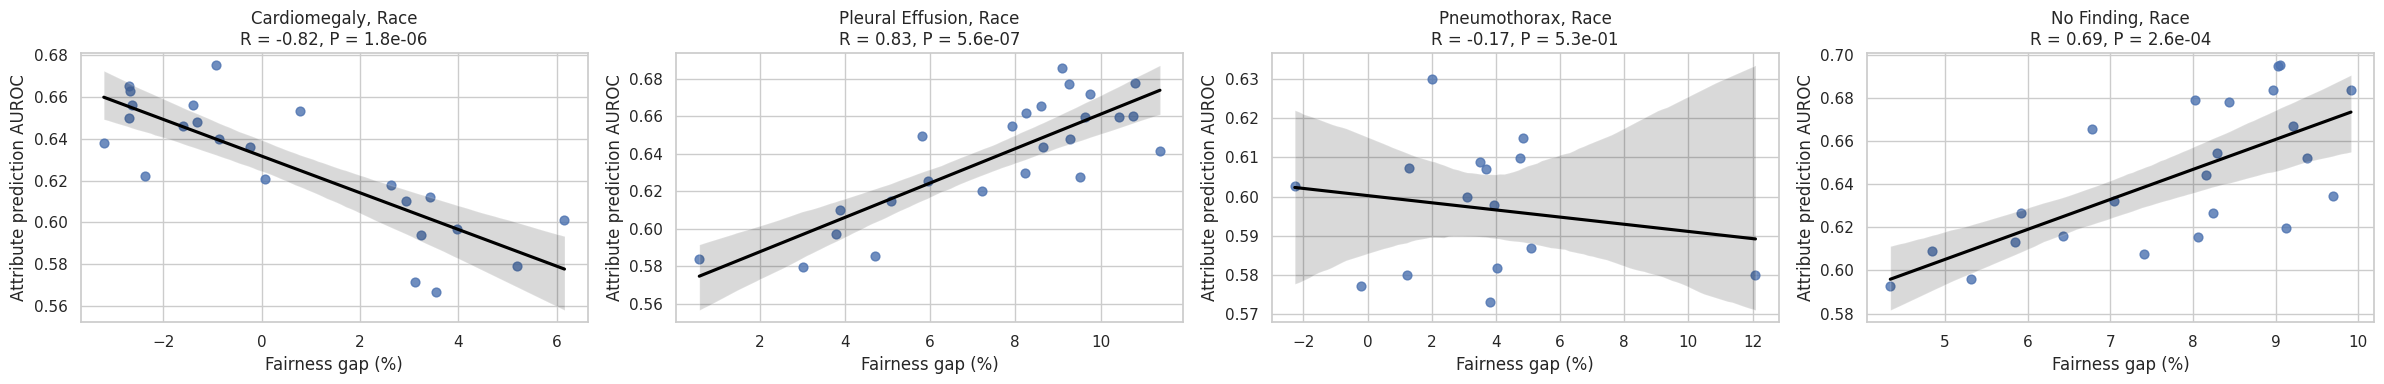

,task,attr,r,p,r_95ci_lower,r_95ci_upper,r_95ci_dif,slope,intercept,pval_slope,slope_95ci_lower,slope_95ci_upper,slope_95ci_dif,r_squared
3,No Finding,race,0.691152,2.603452e-04,0.390075,0.858714,0.468639,0.013895,0.535650,2.603452e-04,0.007302,0.020489,0.013188,0.477691
1,Pleural Effusion,race,0.828912,5.609367e-07,0.639272,0.923507,0.284235,0.009178,0.569321,5.609367e-07,0.006439,0.011916,0.005477,0.687095
0,Cardiomegaly,race,-0.818555,1.810048e-06,-0.920255,-0.613274,0.306981,-0.008788,0.631749,1.810048e-06,-0.011586,-0.005989,0.005597,0.670032
2,Pneumothorax,race,-0.174541,5.338402e-01,-0.630442,0.370892,1.001334,-0.000913,0.600281,5.338402e-01,-0.004001,0.002174,0.006174,0.030465


In [55]:
plot_fairness_vs_attr_auroc(df_race)

In [ ]:
#==========================RACE====================================

In [ ]:
#==========================SEX_RACE================================

In [56]:
# Sex race: 
#white_male ->0, black_female -> 3 : clase 3 - clase 0
df_overall_sex_race, df_attr_sex_race, df_lr_sex_race = process_corr_results(
    attr_name='sex_ethnicity',
    base_dir=Path('/home/lchanch/initial_training/output_sweep_12/grid_sex_race_mimic_12'),
    results_dir=Path('/home/lchanch/models/ERM/eval/corr_eval/'),
    fairness_classes=(3, 0)
)

Total runs for sex_ethnicity: 135
CSV guardados en: /home/lchanch/models/ERM/eval/corr_eval


In [29]:
df_sex_race=merge_dfs(df_overall_sex_race, df_attr_sex_race, df_lr_sex_race, 'sex_ethnicity')

In [57]:
df_sex_race_final=df_sex_race[df_sex_race['overall_val_auroc'] >= 0.7]
#df_sex_race_final.to_csv('/home/lchanch/initial_training/results_output_sweep_12/results_corr_graphics/df_sex_race_up07.csv', index=False)
df_sex_race_final

,store_name,seed,hparams_seed,task,AUROC_attr3,AUROC_attr0,balanced_acc_attr3,balanced_acc_attr0,FNR_opt_attr3,FNR_opt_attr0,...,balanced_acc_va,balanced_acc_te,AUROC_va,attr_lr_auroc_te,class_3_AUROC_va,class_3_AUROC_te,class_0_AUROC_va,class_0_AUROC_te,overall_val_auroc,attribute
3,03508c008a3edfcc4c4a65908557a259,0,3,No Finding,0.773105,0.761618,0.711707,0.702669,0.202703,0.266943,...,0.150684,0.150539,0.601881,0.611704,0.627485,0.628559,0.644675,0.638301,0.778254,sex_ethnicity
4,6dce6c12c447938cd0f7fcbdebc8f46e,2,3,Cardiomegaly,0.734215,0.741770,0.674121,0.679788,0.318093,0.308615,...,0.142713,0.142275,0.581124,0.582810,0.615435,0.613804,0.621096,0.622074,0.740255,sex_ethnicity
7,a5f97055e88cd1f3f1cf3fcff3ec1b56,1,9,Pleural Effusion,0.940119,0.916641,0.827645,0.832825,0.287975,0.214052,...,0.213455,0.215813,0.751914,0.751163,0.779753,0.782704,0.806567,0.812186,0.923085,sex_ethnicity
9,4d380efa4aad47b45a417d8f09fb39e3,1,0,Pleural Effusion,0.912537,0.889206,0.794191,0.783778,0.348101,0.324122,...,0.168219,0.166523,0.641961,0.641784,0.679672,0.683480,0.705053,0.704028,0.894821,sex_ethnicity
10,92bd2a71a87887710a5284b58175c1a1,1,3,No Finding,0.765517,0.761456,0.710767,0.699899,0.277872,0.315054,...,0.155649,0.158547,0.621045,0.627760,0.656775,0.651974,0.659996,0.669707,0.773844,sex_ethnicity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,3fff102f888d6e5b1e5740c81a2b86de,2,1,No Finding,0.841040,0.835962,0.748990,0.768981,0.116976,0.200379,...,0.210917,0.212426,0.729243,0.728934,0.774776,0.772823,0.782225,0.777847,0.845274,sex_ethnicity
130,60b15819d8f5b84f7ceac66c6103732e,1,1,Cardiomegaly,0.834356,0.800883,0.760343,0.726671,0.206226,0.247081,...,0.196180,0.196546,0.731503,0.731774,0.753876,0.758405,0.779841,0.782222,0.815855,sex_ethnicity
131,ec8e5bdbf52c510fb8f6bd609202dde2,2,5,No Finding,0.834368,0.826978,0.761658,0.754319,0.169764,0.279531,...,0.175721,0.174684,0.678831,0.674608,0.713904,0.717673,0.723147,0.716795,0.837261,sex_ethnicity
133,0ca053cab817820508a3321957e06d2c,2,9,Cardiomegaly,0.832941,0.796784,0.761767,0.719526,0.223735,0.285579,...,0.193234,0.191911,0.721766,0.717872,0.757617,0.751464,0.781734,0.778455,0.811212,sex_ethnicity


In [58]:
df_sex_race_corr=df_sex_race_final[['task','fair_gap','attr_lr_auroc_te','attribute']]
df_sex_race_corr

,task,fair_gap,attr_lr_auroc_te,attribute
3,No Finding,4.616372,0.611704,sex_ethnicity
4,Cardiomegaly,0.947868,0.582810,sex_ethnicity
7,Pleural Effusion,7.392316,0.751163,sex_ethnicity
9,Pleural Effusion,2.397949,0.641784,sex_ethnicity
10,No Finding,1.544843,0.627760,sex_ethnicity
...,...,...,...,...
129,No Finding,12.338661,0.728934,sex_ethnicity
130,Cardiomegaly,-4.085542,0.731774,sex_ethnicity
131,No Finding,9.508890,0.674608,sex_ethnicity
133,Cardiomegaly,-6.184364,0.717872,sex_ethnicity


results
Cardiomegaly
sex_ethnicity
valores con overall_val_auroc > 0.7:  24
r =  -0.7237734213055093
p =  6.399937927067641e-05
results
Pneumothorax
sex_ethnicity
valores con overall_val_auroc > 0.7:  15
r =  -0.1341835858223733
p =  0.6335248672105604
results
Pleural Effusion
sex_ethnicity
valores con overall_val_auroc > 0.7:  24
r =  0.7634460060081527
p =  1.425823488037268e-05
results
No Finding
sex_ethnicity
valores con overall_val_auroc > 0.7:  24
r =  0.7313121585822459
p =  4.9084216332515615e-05


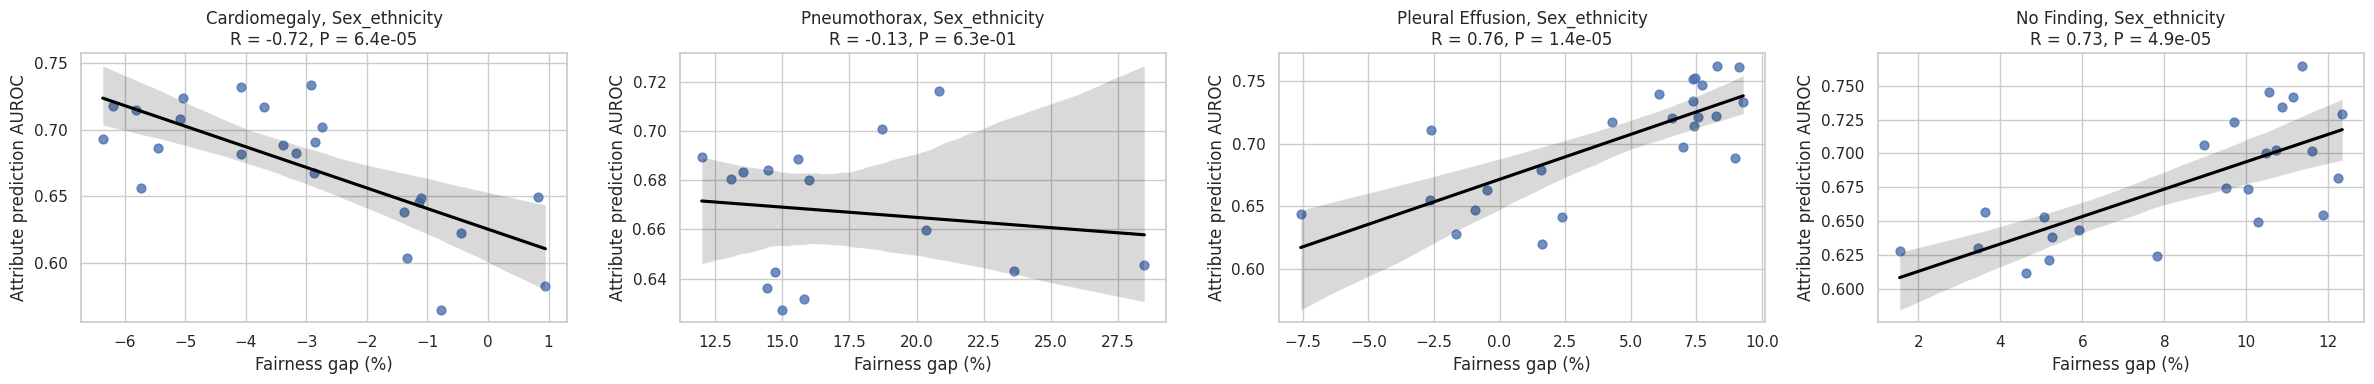

,task,attr,r,p,r_95ci_lower,r_95ci_upper,r_95ci_dif,slope,intercept,pval_slope,slope_95ci_lower,slope_95ci_upper,slope_95ci_dif,r_squared
3,No Finding,sex_ethnicity,0.731312,0.000049,0.465128,0.876219,0.411091,0.010124,0.592641,0.000049,0.005949,0.014298,0.008349,0.534817
2,Pleural Effusion,sex_ethnicity,0.763446,0.000014,0.520275,0.892103,0.371827,0.007150,0.671542,0.000014,0.004475,0.009824,0.005349,0.582850
0,Cardiomegaly,sex_ethnicity,-0.723773,0.000064,-0.872446,-0.452483,0.419964,-0.015447,0.625425,0.000064,-0.021959,-0.008936,0.013023,0.523848
1,Pneumothorax,sex_ethnicity,-0.134184,0.633525,-0.604876,0.405994,1.010870,-0.000833,0.681518,0.633525,-0.004518,0.002853,0.007371,0.018005


In [59]:
plot_fairness_vs_attr_auroc(df_sex_race)

In [ ]:
#==========================SEX_RACE================================

In [ ]:
#==========================AGE=====================================

In [60]:
# Age:  18–40(3) - 80–100(0)  
df_overall_age, df_attr_age, df_lr_age=process_corr_results(
    attr_name='age',
    base_dir=Path('/home/lchanch/initial_training/output_sweep_12/grid_age_mimic_12'),
    results_dir=Path('/home/lchanch/models/ERM/eval/corr_eval/'),
    fairness_classes=(3, 0)
)

Total runs for age: 135
CSV guardados en: /home/lchanch/models/ERM/eval/corr_eval


In [61]:
df_age=merge_dfs(df_overall_age, df_attr_age, df_lr_age, 'age')

In [62]:
df_age_final=df_age[df_age['overall_val_auroc'] >= 0.7]
#df_age_final.to_csv('/home/lchanch/initial_training/results_output_sweep_12/results_corr_graphics/df_age_up07.csv', index=False)
df_age_final

,store_name,seed,hparams_seed,task,AUROC_attr3,AUROC_attr0,balanced_acc_attr3,balanced_acc_attr0,FNR_opt_attr3,FNR_opt_attr0,...,balanced_acc_va,balanced_acc_te,AUROC_va,attr_lr_auroc_te,class_3_AUROC_va,class_3_AUROC_te,class_0_AUROC_va,class_0_AUROC_te,overall_val_auroc,attribute
0,c2e4efad973092323dcfa0bbcbdbb212,2,0,Pleural Effusion,0.906943,0.869432,0.722936,0.767643,0.521739,0.351523,...,0.282581,0.280799,0.628491,0.628804,0.650078,0.676250,0.673742,0.660288,0.886403,age
2,c0e27393a407076be5bd0d11521839be,0,5,Pleural Effusion,0.938515,0.913489,0.819854,0.837792,0.306238,0.139609,...,0.310222,0.311274,0.657907,0.664586,0.701862,0.735896,0.695791,0.697596,0.919060,age
3,7e52cb5bd96dc57de34403a7d298cd1d,1,8,No Finding,0.796538,0.759474,0.695726,0.673969,0.054557,0.460845,...,0.341719,0.336778,0.691762,0.686583,0.745488,0.756020,0.740914,0.732529,0.810780,age
4,12dadaf66c3a13d465f2cc07b0272ebd,0,7,No Finding,0.836613,0.789022,0.750674,0.674508,0.068605,0.539718,...,0.347079,0.341704,0.683702,0.681184,0.729811,0.756299,0.734015,0.725298,0.834656,age
5,32392bff6e93f5f84437c5d6e0950b09,1,7,Cardiomegaly,0.848441,0.742287,0.720907,0.673694,0.456660,0.212325,...,0.314306,0.319437,0.657238,0.662224,0.703075,0.735824,0.700749,0.693573,0.805573,age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,055a4f3474733a042d87809d58cd1617,2,5,No Finding,0.833495,0.790737,0.740500,0.693880,0.057498,0.482254,...,0.337912,0.334272,0.688057,0.684294,0.737022,0.755200,0.743793,0.734941,0.837261,age
128,ffeb1e20d3aaed00d29e5b4e7eb21577,2,8,Pleural Effusion,0.918714,0.879324,0.781142,0.803350,0.387524,0.190541,...,0.287071,0.288143,0.647332,0.649467,0.701823,0.706716,0.679564,0.687452,0.896101,age
130,d1fa3dbe7d0713e35c36e9de0ba21369,2,9,Cardiomegaly,0.850253,0.755377,0.717122,0.685618,0.479915,0.305023,...,0.366089,0.358294,0.700653,0.699660,0.774543,0.788388,0.740146,0.736424,0.811212,age
133,adf770f0a2cf843e364ccd6803389eb0,0,1,Pleural Effusion,0.943159,0.917486,0.825780,0.843523,0.298677,0.135516,...,0.346959,0.353064,0.699545,0.706336,0.768339,0.798250,0.733421,0.739098,0.921744,age


In [63]:
df_age_corr=df_age_final[['task','fair_gap','attr_lr_auroc_te']]
df_age_corr

,task,fair_gap,attr_lr_auroc_te
0,Pleural Effusion,17.021571,0.628804
2,Pleural Effusion,16.662927,0.664586
3,No Finding,36.277298,0.686583
4,No Finding,31.878033,0.681184
5,Cardiomegaly,24.433440,0.662224
...,...,...,...
127,No Finding,33.151634,0.684294
128,Pleural Effusion,19.698247,0.649467
130,Cardiomegaly,17.489213,0.699660
133,Pleural Effusion,16.316060,0.706336


results
Pleural Effusion
age
valores con overall_val_auroc > 0.7:  24
r =  -0.22735864405378747
p =  0.28532356775460704
results
Cardiomegaly
age
valores con overall_val_auroc > 0.7:  24
r =  0.2147938465605806
p =  0.3134909331153824
results
No Finding
age
valores con overall_val_auroc > 0.7:  24
r =  -0.6809397277674256
p =  0.00024966333460763333
results
Pneumothorax
age
valores con overall_val_auroc > 0.7:  15
r =  -0.16343361309443405
p =  0.5605677434820471


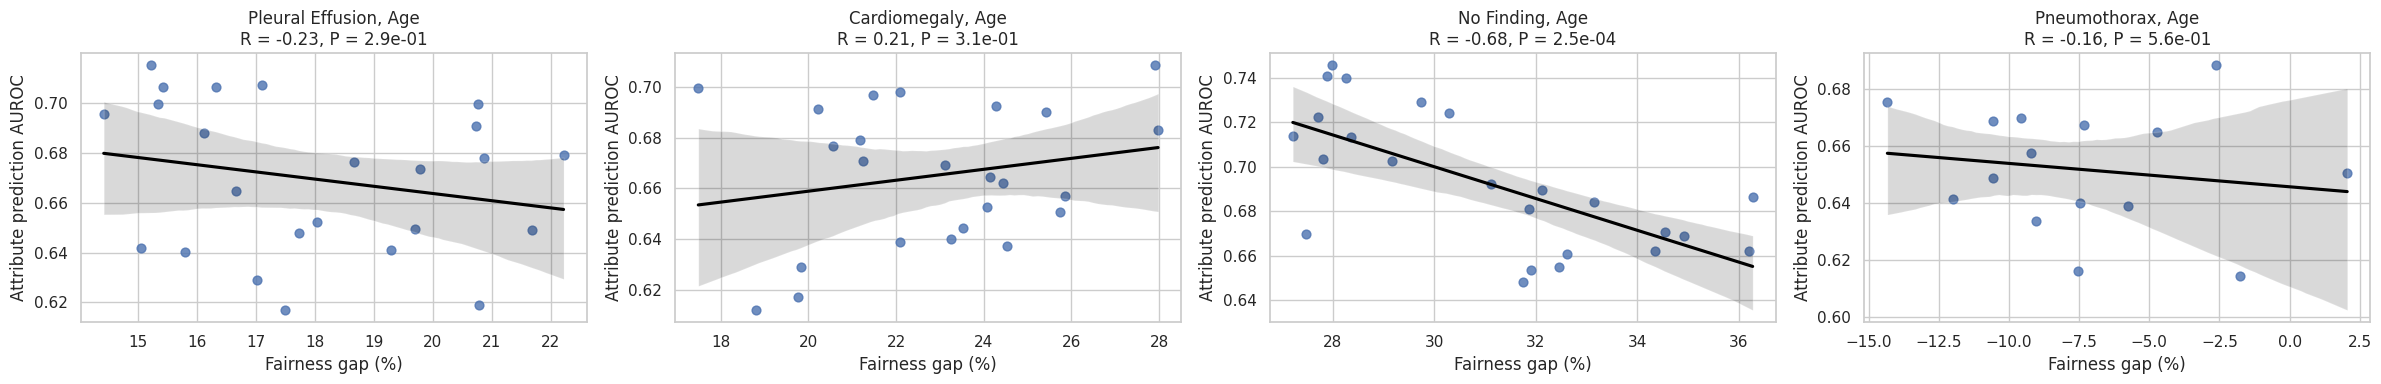

,task,attr,r,p,r_95ci_lower,r_95ci_upper,r_95ci_dif,slope,intercept,pval_slope,slope_95ci_lower,slope_95ci_upper,slope_95ci_dif,r_squared
2,No Finding,age,-0.680940,0.000250,-0.850670,-0.382647,0.468023,-0.007145,0.914436,0.000250,-0.010543,-0.003748,0.006796,0.463679
0,Pleural Effusion,age,-0.227359,0.285324,-0.577770,0.193821,0.771592,-0.002884,0.721343,0.285324,-0.008347,0.002578,0.010925,0.051692
1,Cardiomegaly,age,0.214794,0.313491,-0.206503,0.568903,0.775405,0.002162,0.615637,0.313491,-0.002184,0.006508,0.008692,0.046136
3,Pneumothorax,age,-0.163434,0.560568,-0.623503,0.380711,1.004214,-0.000818,0.645611,0.560568,-0.003779,0.002142,0.005921,0.026711


In [64]:
plot_fairness_vs_attr_auroc(df_age)

In [ ]:
#==========================AGE=====================================